# Qutrit Machine Learning Optimizaiton 

Author: Bora Basyildiz

## Imports

In [1]:
import torch
import numpy as np
from itertools import permutations
from itertools import product
import matplotlib.pyplot as plt

## Qutrit Fidelity Calculation

In [46]:
def fidelity_Qutrit(J,B,M,input_gate,t,N_iter):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex

    This function extends the architecture from 
    """
    #imports

    #Gell-Mann Matricies 
    l1 = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) #~X for 0->1 transition
    l2 = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) #~Y for 0->1 transition
    l3 = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) #~Z for qubit regime
    l4 = np.array([[0,0,1],[0,0,0],[1,0,0]]) #~X for 0->2 transition
    l5 = np.array([[0,0,-1j],[0,0,0],[1j,0,0]]) #~Y for 0->2 transition
    l6 = np.array([[0,0,0],[0,0,1],[0,1,0]]) #~X for 1->2 transition
    l7 = np.array([[0,0,0],[0,0,-1j],[0,1j,0]]) #~Y for 1->2 transition
    l8 = 1/np.sqrt(3) * np.array([[1,0,0],[0,1,0],[0,0,-2]]) #Some sort of phase gate
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) #Aye, if you don't know the identity at this point, its maybe time for another career.

    # Annhilation and Creation Operators (used for PRA Hamiltonian)
    annhilate = np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
    create = annhilate.T
    
    #Function definitions 
    def zero_mat(N):#Generates matrix of zeros
        zero_gate = np.array([[0,0,0],[0,0,0],[0,0,0]])
        init = zero_gate
        if N < 2:
            return 1
        for i in range(0,N - 1):
            zero_gate = torch.tensor(np.kron(zero_gate,init),dtype=torch.cdouble)
        return zero_gate
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        N = len(coef)#number of qubits
        total_pauli = zero_mat(N)
        #Summing all Z gates
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            total_pauli = total_pauli + coef[i]*pauli_temp
        #return torch.tensor(total_pauli,dtype=torch.cdouble)
        return total_pauli

    #variable initializations
    N = len(B)
    torch.manual_seed(1)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #J coefficients gathering (only if J is in N x N matrix, otherwise set J_coef=J) <- essentially flattens the array
    J_coef = []
    for i in range(0,len(J) - 1):
        for j in range(0,len(J) - i - 1):
            J_coef.append(J[i,j].item())

    #H0 generation
    permuts = [1,1]
    for i in range(2,N):
        permuts.append(0)
    permuts = list(set(permutations(permuts,N)))
    permuts.sort()
    permuts.reverse()#All permutations of ZZ coupling stored as bit arrays
    H0 = zero_mat(N)
    ##Changed gates ZZ -> XX
    for i,u in enumerate(permuts):
        H0_temp = 1
        for p in u:
            if p==1:
                H0_temp = torch.tensor(np.kron(H0_temp,(annhilate + create)))
            else:
                H0_temp = torch.tensor(np.kron(H0_temp,id))
        H0 = H0 + J_coef[i]*H0_temp

    #Orthonormal Matrix Generation 
    def Matrix_Basis_Gen(d):
        X = np.zeros([d,d])
        for i in range(d):
            X[(i+1) % d,i] = 1
        Z = np.zeros([d,d],dtype=np.complex_)
        for i in range(d):
            Z[i,i] = np.exp((2*np.pi * 1j * i)/d)
        Basis = []
        for i in range(d):
            for j in range(d):
                Basis.append(torch.tensor(np.matmul(np.linalg.matrix_power(X,i),np.linalg.matrix_power(Z,j)),dtype=torch.cdouble))
        return Basis

    #These are the coefficients we are optimizing
    R = torch.rand([M,4*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate

    #Optimizer settings(can be changed & opttimized)
    lr=0.3#learning rate

    opt = 'SGD'  # Choose optimizer - ADAM, SGD (typical). ADAMW, ADAMax, Adadelta,  
                        # Adagrad, Rprop, RMSprop, ASGD, also valid options.     
    sched = 'Plateau'  # Choose learning rate scheduler - Plateau, Exponential (typical), Step
    
    if opt=='ADAM': optimizer = torch.optim.Adam([R], lr = lr, weight_decay=1e-6)
    elif opt=='ADAMW': optimizer = torch.optim.AdamW([R], lr = lr, weight_decay=0.01)
    elif opt=='ADAMax': optimizer = torch.optim.Adamax([R], lr = lr, weight_decay=0.01)
    elif opt=='RMSprop': optimizer = torch.optim.RMSprop([R], lr = lr, momentum=0.2)
    elif opt=='Rprop': optimizer = torch.optim.Rprop([R], lr = lr)
    elif opt=='Adadelta': optimizer = torch.optim.Adadelta([R], lr = lr) 
    elif opt=='Adagrad': optimizer = torch.optim.Adagrad([R], lr = lr)
    elif opt=='SGD': optimizer = torch.optim.SGD([R], lr = lr, momentum=0.99, nesterov=True)
    elif opt=='ASGD': optimizer = torch.optim.ASGD([R], lr = lr)
    else: optimizer=None; opt='None'
        
    if sched=='Step': scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=N_iter/10, gamma=0.9)
    elif sched=='Exponential': scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    elif sched=='Plateau': scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 ); loss_in=True; 
    else: scheduler=None; sched='None'

    for n in range(0,N_iter):
        #Creating Drive Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],l1) + sum_pauli(pulse_coef[N:2*N],l2) + sum_pauli(pulse_coef[2*N:3*N],l6) + sum_pauli(pulse_coef[3*N:4*N],l7) 
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 3**N
        
        for U in Matrix_Basis_Gen(d):
            ideal_U = torch.matmul(torch.matmul(input_gate,U.conj().T),(input_gate.conj().T))
            target_U = torch.matmul(torch.matmul(U_Exp,U),(U_Exp.conj().T)) # This is Eps(U) = pulse_gate * pauli * pulse_gate^H
            tr = torch.trace(torch.matmul(ideal_U,target_U))
            fidelity = fidelity + tr 
        fidelity = abs(fidelity + d**2)/(d**2 *(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        if (n+1)%1000==0: 
            print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        if optimizer is not None and scheduler is None:  # Update R
            optimizer.step()
            optimizer.zero_grad()
        elif optimizer is not None and scheduler is not None:
            optimizer.step()
            if loss_in: 
                scheduler.step(infidelity)
            else: 
                scheduler.step()
            optimizer.zero_grad()
        else:
            R.data.sub_(lr*R.grad.data) # using data avoids overwriting tensor object
            R.grad.data.zero_()           # and it's respective grad info
    
    #print('The infidelity of the generated gate is: ' + str(infidelity_list.min().item()))
    #return R
    return infidelity_list.min().item()

In [59]:
def fidelity_subQutrit(J,B,M,input_gate,t,N_iter):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex


    This function is essentially the qubit optimization done by Alex & I in Joel's experiment. However, we are now operating in a Qutrit System have no drives to the higher levels. 
    Hence this code can be thought as a simple extension of the qubit fidelity_ml code.
    """
    #imports

    #Pauli Matricies in Qutrit space
    sx = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    sy = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    sz = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]])

    # Annhilation and Creation Operators (for PRA Hamiltonian)
    annhilate = np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
    create = annhilate.T
    
    #Function definitions 
    def zero_mat(N):#Generates matrix of zeros
        zero_gate = np.array([[0,0,0],[0,0,0],[0,0,0]])
        init = zero_gate
        if N < 2:
            return 1
        for i in range(0,N - 1):
            zero_gate = torch.tensor(np.kron(zero_gate,init))
        return zero_gate
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        N = len(coef)#number of qubits
        total_pauli = zero_mat(N)
        #Summing all Z gates
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = len(B)
    torch.manual_seed(9)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #J coefficients gathering (only if J is in N x N matrix, otherwise set J_coef=J) <- essentially flattens the array
    J_coef = []
    for i in range(0,len(J) - 1):
        for j in range(0,len(J) - i - 1):
            J_coef.append(J[i,j].item())

    #H0 generation
    permuts = [1,1]
    for i in range(2,N):
        permuts.append(0)
    permuts = list(set(permutations(permuts,N)))
    permuts.sort()
    permuts.reverse()#All permutations of coupling stored as bit arrays
    H0 = zero_mat(N)
    for i,u in enumerate(permuts):
        Coupling_temp = 1
        for p in u:
            if p==1:
                Coupling_temp = torch.tensor(np.kron(Coupling_temp,annhilate + create))
            else:
                Coupling_temp = torch.tensor(np.kron(Coupling_temp,id))
        H0 = H0 + J_coef[i]*Coupling_temp

    #Unitary group generation
    SU = []
    pauli_int = [1,2,3,4]
    perms = list(product(pauli_int,repeat=N))#all permutations of paulis
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1:
                unitary = torch.tensor(np.kron(unitary,sx),dtype=torch.cdouble)
            elif pauli == 2:
                unitary = torch.tensor(np.kron(unitary,sy),dtype=torch.cdouble)
            elif pauli == 3:
                unitary = torch.tensor(np.kron(unitary,sz),dtype=torch.cdouble)
            elif pauli == 4:
                unitary = torch.tensor(np.kron(unitary,id),dtype=torch.cdouble)
        SU.append(unitary)

    #These are the coefficients we are optimizing
    R = torch.rand([M,2*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate

    #Optimizer settings(can be changed & opttimized)
    lr=0.3#learning rate

    opt = 'SGD'  # Choose optimizer - ADAM, SGD (typical). ADAMW, ADAMax, Adadelta,  
                        # Adagrad, Rprop, RMSprop, ASGD, also valid options.     
    sched = 'Plateau'  # Choose learning rate scheduler - Plateau, Exponential (typical), Step
    
    if opt=='ADAM': optimizer = torch.optim.Adam([R], lr = lr, weight_decay=1e-6)
    elif opt=='ADAMW': optimizer = torch.optim.AdamW([R], lr = lr, weight_decay=0.01)
    elif opt=='ADAMax': optimizer = torch.optim.Adamax([R], lr = lr, weight_decay=0.01)
    elif opt=='RMSprop': optimizer = torch.optim.RMSprop([R], lr = lr, momentum=0.2)
    elif opt=='Rprop': optimizer = torch.optim.Rprop([R], lr = lr)
    elif opt=='Adadelta': optimizer = torch.optim.Adadelta([R], lr = lr) 
    elif opt=='Adagrad': optimizer = torch.optim.Adagrad([R], lr = lr)
    elif opt=='SGD': optimizer = torch.optim.SGD([R], lr = lr, momentum=0.99, nesterov=True)
    elif opt=='ASGD': optimizer = torch.optim.ASGD([R], lr = lr)
    else: optimizer=None; opt='None'
        
    if sched=='Step': scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=N_iter/10, gamma=0.9)
    elif sched=='Exponential': scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    elif sched=='Plateau': scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 ); loss_in=True; 
    else: scheduler=None; sched='None'

    for n in range(0,N_iter):
        #Creating Drive Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:],sy)
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 2**N
        
        for U in SU:
            eps_U = torch.matmul(torch.matmul(U_Exp,U),(U_Exp.conj().T))
            target_U = torch.matmul(torch.matmul(input_gate,(U.conj().T)),(input_gate.conj().T))
            tr = torch.trace(torch.matmul(target_U,eps_U))
            fidelity = fidelity + tr
        fidelity = abs(fidelity + d*d)/(d*d*(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        if (n+1)%50==0: 
            print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        if optimizer is not None and scheduler is None:  # Update R
            optimizer.step()
            optimizer.zero_grad()
        elif optimizer is not None and scheduler is not None:
            optimizer.step()
            if loss_in: 
                scheduler.step(infidelity)
            else: 
                scheduler.step()
            optimizer.zero_grad()
        else:
            R.data.sub_(lr*R.grad.data) # using data avoids overwriting tensor object
            R.grad.data.zero_()           # and it's respective grad info
    
    #print('The infidelity of the generated gate is: ' + str(infidelity_list.min().item()))
    #return R
    return infidelity_list.min().item()

## Qutrit Testing

In [60]:
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
Identity = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])
#pulse_frequencies = fidelity_Qutrit(J,[1,1],24,CNOT_qutrit,np.pi/4,100000)
fidelity_subQutrit(J,[1,1],32,CNOT_qutrit,np.pi/4,1000)

Itertation  50  out of  1000 complete. Avg Infidelity:  0.7336140970899087
Itertation  100  out of  1000 complete. Avg Infidelity:  0.6228785741094471
Itertation  150  out of  1000 complete. Avg Infidelity:  0.5835884851718905
Itertation  200  out of  1000 complete. Avg Infidelity:  0.523540415836686
Itertation  250  out of  1000 complete. Avg Infidelity:  0.4545492912721375
Itertation  300  out of  1000 complete. Avg Infidelity:  0.3696911548532861
Itertation  350  out of  1000 complete. Avg Infidelity:  0.3061372275819393
Itertation  400  out of  1000 complete. Avg Infidelity:  0.23973337254611882
Itertation  450  out of  1000 complete. Avg Infidelity:  0.19685337122684154
Itertation  500  out of  1000 complete. Avg Infidelity:  0.16489847697258586
Itertation  550  out of  1000 complete. Avg Infidelity:  0.13239412302630704
Itertation  600  out of  1000 complete. Avg Infidelity:  0.10913433842134135
Itertation  650  out of  1000 complete. Avg Infidelity:  0.09279556649455911
Itertati

0.04909830912947655

Text(0.5, 1.0, '2 Qutrit CNOT Fidelity for XX coupled H0')

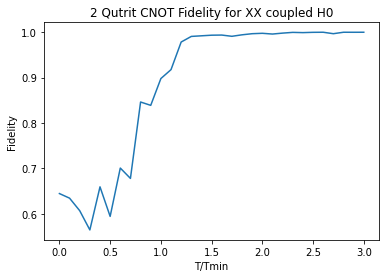

In [ ]:
#graph generation for CNOT Qutrit Gate
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])

Fidelities = []
Times = []
for i in range(0,31):
    Times.append(i/10)
    Fidelities.append(1 - fidelity_Qutrit(J,[1,1],16,CNOT_qutrit,i/10*np.pi/4,1000))

plt.plot(Times,Fidelities)
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("2 Qutrit CNOT Fidelity for XX coupled H0")

Text(0.5, 1.0, '2 Qutrit Identity Fidelity for XX coupled H0')

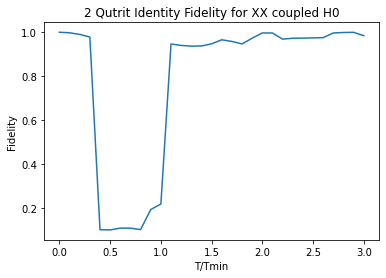

In [ ]:
#graph generation for Identity Gate 
Identity = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])

Fidelities = []
Times = []
for i in range(0,31):
    Times.append(i/10)
    Fidelities.append(1 - fidelity_Qutrit(J,[1,1],16,Identity,i/10*np.pi/4,1000))

plt.plot(Times,Fidelities)
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("2 Qutrit Identity Fidelity for XX coupled H0")

## Qutrit Matrix Basis Generation Explanation 

We want a matrix basis that is orthonormal AND unitary. While the Gell-Mann matrices are orthonormal, they are not unitary. Now we will generate these matrices through the method outlined by the Nielsen paper 

In [ ]:
def Matrix_Basis_Gen(d):
            X = np.zeros([d,d])
            for i in range(d):
                X[(i+1) % d,i] = 1
            Z = np.zeros([d,d],dtype=np.complex_)
            for i in range(d):
                Z[i,i] = np.exp((2*np.pi * 1j * i)/d)
            Basis = []
            for i in range(d):
                for j in range(d):
                    Basis.append(torch.tensor(np.matmul(np.linalg.matrix_power(X,i),np.linalg.matrix_power(Z,j)),dtype=torch.cdouble))
            return Basis

In [ ]:
Matrix_Basis_Gen(2)

[tensor([[1.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j]], dtype=torch.complex128),
 tensor([[ 1.+0.0000e+00j,  0.+0.0000e+00j],
         [ 0.+0.0000e+00j, -1.+1.2246e-16j]], dtype=torch.complex128),
 tensor([[0.+0.j, 1.+0.j],
         [1.+0.j, 0.+0.j]], dtype=torch.complex128),
 tensor([[ 0.+0.0000e+00j, -1.+1.2246e-16j],
         [ 1.+0.0000e+00j,  0.+0.0000e+00j]], dtype=torch.complex128)]

In [ ]:
annhilate = np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
create = annhilate.T
print(torch.tensor(np.kron((annhilate + create),(annhilate + create))))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000],
        [1.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 2.0000],
        [0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
